# Project Tour: Replication of "Coronavirus: Impact on Stock Prices and Growth Expectations"

This notebook provides a brief tour of our project replicating the paper by Niels J. Gormsen and Ralph S.J. Koijen (2020): "Coronavirus: Impact on Stock Prices and Growth Expectations".

In this tour, we'll explore:
1. The data sources we used
2. How we processed the raw data
3. Key figure replications
4. Extension of the analysis with updated data

Let's begin by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime
from settings import config
from calc_functions import calc_pct_returns

# Get configuration values
DATA_DIR = config("DATA_DIR")
OUTPUT_DIR = config("OUTPUT_DIR")
START_DATE = config("START_DATE")
PAPER_END_DATE = config("PAPER_END_DATE")
CURR_END_DATE = config("CURR_END_DATE")


## 1. Project Overview

The paper by Gormsen and Koijen examines how financial markets responded to the COVID-19 pandemic in early 2020. The authors use data from equity and dividend futures markets to extract insights about investors' expectations for economic growth.

Key components of our replication include:
* Reproducing Figure 1 showing the response of stock and bond markets
* Replicating the calculation of growth expectations from dividend futures
* Extending the analysis with data beyond the paper's original time frame

For this replication, we primarily focused on the following figures and analyses from the paper:
- Figure 1: The response of stock and bond markets
- Table 1: Predictive Regressions of Dividend Growth on Dividend Yields
- Figure 5: Expected dividend and GDP growth


Let's examine each component of our replication in more detail.

## 2. Data Sources

Our replication relies on the following data sources:

1. **Stock Market Indices**: S&P 500 (US), Euro Stoxx 50 (EU), and Nikkei 225 (Japan)
2. **30-year Treasury Yields**: US, Germany, and Japan
3. **Dividend Data**: Actual dividend values for the three indices
4. **Dividend Futures**: Futures contracts on dividends for the three indices

We obtained this data from Bloomberg terminals, with a fallback to CSV files when Bloomberg access wasn't available.

Let's load some of our cleaned data to examine:

In [2]:
# Load cleaned index data
clean_index_path = Path(DATA_DIR) / "clean" / "index_data_clean.parquet"
if clean_index_path.exists():
    index_data = pd.read_parquet(clean_index_path)
    print(f"Index data shape: {index_data.shape}")
    display(index_data.head())
else:
    print("Index data file not found. Run data cleaning first.")

Index data shape: (173, 6)


,SPX Index,SX5E Index,NKY Index,USGG30YR Index,GDBR30 Index,GJGB30 Index
Date,,,,,,
2020-01-01,NaN,NaN,NaN,2.3896,0.349,0.425
2020-01-02,3257.85,3793.24,NaN,2.3312,0.307,0.425
2020-01-03,3234.85,3773.37,NaN,2.2444,0.251,0.425
2020-01-06,3246.28,3752.52,23204.86,2.2858,0.249,0.411
2020-01-07,3237.18,3759.25,23575.72,2.3052,0.256,0.440


In [3]:
# Load dividend data
div_data_path = Path(DATA_DIR) / "clean" / "dividend_data_clean.parquet"
if div_data_path.exists():
    div_data = pd.read_parquet(div_data_path)
    print(f"Dividend data shape: {div_data.shape}")
    display(div_data.head())
else:
    print("Dividend data file not found. Run data cleaning first.")

Dividend data shape: (4986, 4)


,Unnamed: 0,US_Dividend,EU_Dividend,JP_Dividend
Date,,,,
2006-01-02,0,NaN,0.975908,NaN
2006-01-03,1,0.225187,0.975908,NaN
2006-01-04,2,0.225288,0.975901,1.332320
2006-01-05,3,0.225253,0.975928,1.332426
2006-01-06,4,0.225378,0.975933,1.332328


In [4]:
# Load dividend futures data
fut_data_path = Path(DATA_DIR) / "clean" / "dividend_futures_clean.parquet"
if fut_data_path.exists():
    fut_data = pd.read_parquet(fut_data_path)
    print(f"Dividend futures data shape: {fut_data.shape}")
    display(fut_data.head())
else:
    print("Dividend futures data file not found. Run data cleaning first.")

Dividend futures data shape: (4325, 3)


,US_Div_Future,EU_Div_Future,JP_Div_Future
Date,,,
2008-06-30,NaN,142.2,NaN
2008-07-01,NaN,141.0,NaN
2008-07-02,NaN,139.6,NaN
2008-07-03,NaN,138.8,NaN
2008-07-04,NaN,137.6,NaN


## 3. Data Processing

Our data processing pipeline consists of several key steps:

1. **Data Collection**: We collect data from Bloomberg or load from CSV files
2. **Data Cleaning**: We standardize formats, rename columns, handle missing values, and resample data to quarterly frequency (end of quarter)
3. **Calculations**: We compute percentage returns and other metrics

Our final merged cleaned dividend dataset:

In [5]:
fut_data_path = Path(DATA_DIR) / "clean" / "merged_dividend_data_quarterly.parquet"
if fut_data_path.exists():
    fut_data = pd.read_parquet(fut_data_path)
    print(f"Merged quarterly dividend data shape: {fut_data.shape}")
    display(fut_data.head())
else:
    print("Merged data file not found. Run data cleaning first.")

Merged quarterly dividend data shape: (77, 7)


,Unnamed: 0,US_Dividend,EU_Dividend,JP_Dividend,US_Div_Future,EU_Div_Future,JP_Div_Future
Date,,,,,,,
2006-03-31,64,0.231425,0.990218,1.556694,NaN,NaN,NaN
2006-06-30,129,0.236562,1.168311,1.546797,NaN,NaN,NaN
2006-09-30,194,0.242524,1.191738,1.689041,NaN,NaN,NaN
2006-12-31,259,0.251309,1.204712,1.709319,NaN,NaN,NaN
2007-03-31,323,0.258412,1.226463,1.911495,NaN,NaN,NaN


## 4. Figure 1 Replication

Figure 1 shows the response of stock and bond markets during the early COVID-19 period. Let's examine our replication of this figure:

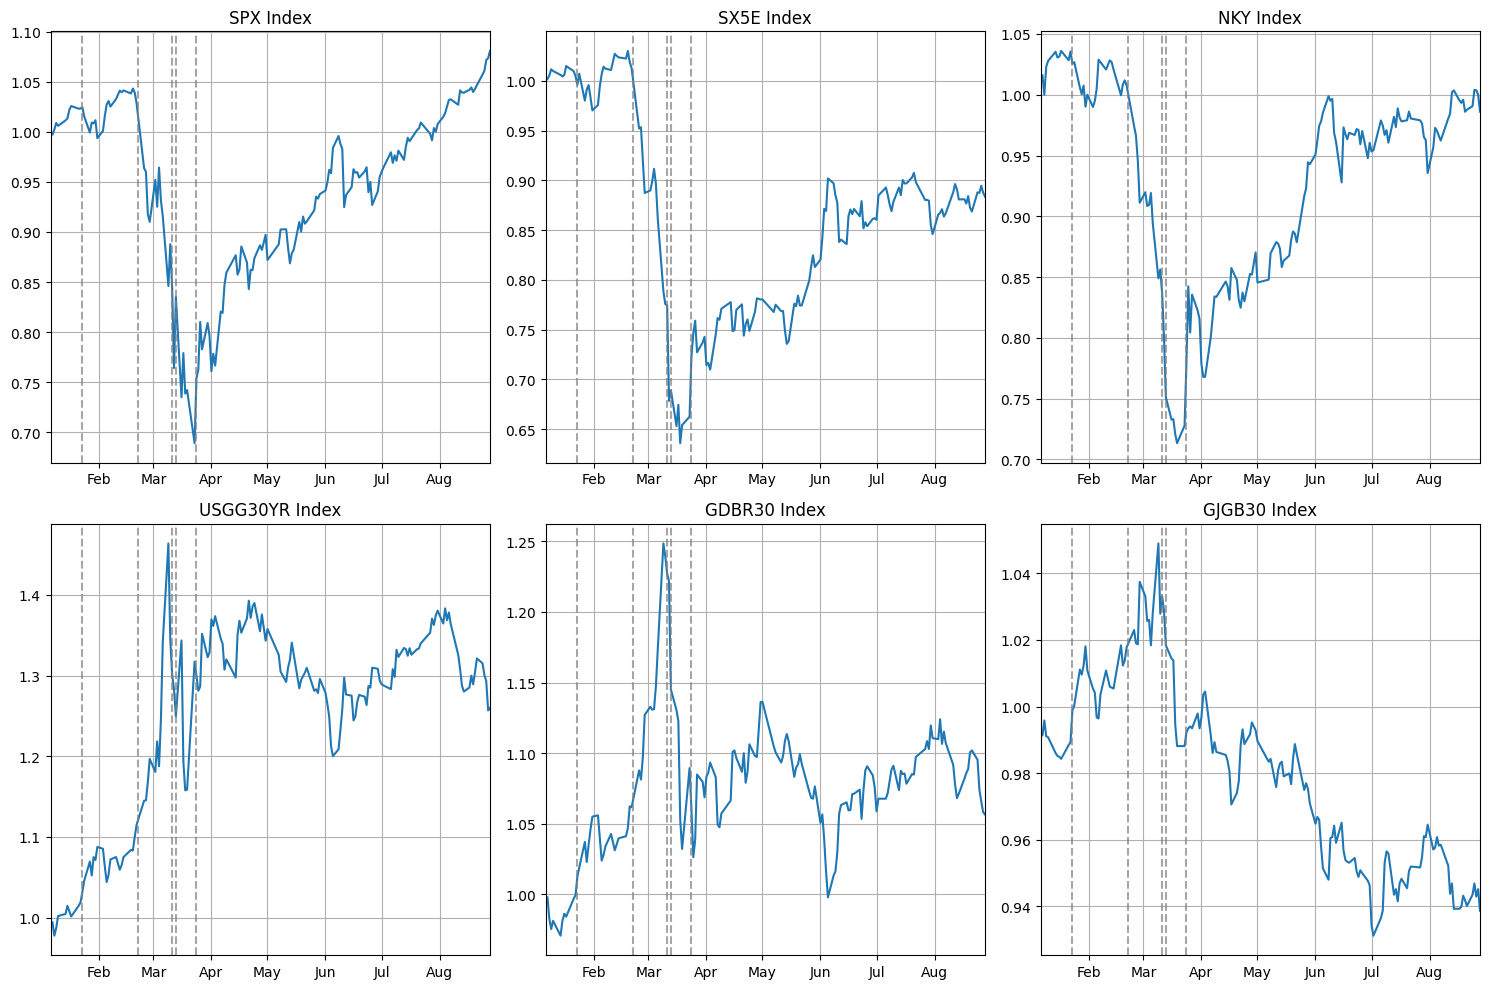

In [6]:
# Calculate percentage returns
returns = calc_pct_returns(DATA_DIR)

# Create a figure similar to Figure 1
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    axes[i].plot(returns.index, returns[col], label=col)
    axes[i].set_title(col)
    axes[i].set_xlim([returns.index[0], returns.index[-1]])
    
    # Generate ticks at the start of each month
    xticks = pd.date_range(start=returns.index[0], end=returns.index[-1], freq="MS")
    axes[i].set_xticks(xticks)
    axes[i].set_xticklabels([x.strftime("%b") for x in xticks])
    axes[i].grid()
    
    # Add vertical lines for key events
    key_dates = [
        pd.Timestamp('2020-01-23'),  # Wuhan lockdown
        pd.Timestamp('2020-02-22'),  # Italy quarantine
        pd.Timestamp('2020-03-11'),  # US travel ban
        pd.Timestamp('2020-03-13'),  # US emergency declaration
        pd.Timestamp('2020-03-24')   # US stimulus news
    ]
    
    for date in key_dates:
        if date >= returns.index[0] and date <= returns.index[-1]:
            axes[i].axvline(x=date, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 5. Table 1 Replication: Predictive Regressions of Dividend Growth on Dividend Yields

Table 1 in the paper shows results from predictive regressions similar to equation (3), where realized dividend growth is regressed onto the ex-ante two-year dividend yield. This is a key part of the methodology used to forecast dividend growth from dividend futures.


In [7]:
import pandas as pd

# Load the regression results
df = pd.read_csv('../_output/tables/table1_results.csv')

# Extract the key values
try:
    # Find the coefficient on equity yield (e_it^(2))
    equity_yield_coef = df.loc[0, '$e_{it}^{(2)}$'] if '$e_{it}^{(2)}$' in df.columns else "Not found"
    
    # Get the R-squared value
    r_squared = df.loc[0, '$R^2$'] if '$R^2$' in df.columns else "Not found"
    
    # Get number of observations
    n_obs = df.loc[0, '\# Obs'] if '\# Obs' in df.columns else "Not found"
    
    # Print just the key findings
    print("Key regression findings:")
    print(f"- Coefficient on equity yield: {equity_yield_coef}")
    print(f"- R²: {r_squared}")
    print(f"- Number of observations: {n_obs}")
    print("This regression relates dividend yields to future dividend growth, which is essential for forecasting growth expectations")
    
except Exception as e:
    print(f"Error extracting values: {e}")
    print("Column names in the dataframe:", df.columns.tolist())

Key regression findings:
- Coefficient on equity yield: -23.25
(18.79)
- R²: 0.04
- Number of observations: 79
This regression relates dividend yields to future dividend growth, which is essential for forecasting growth expectations


## 6. Figure 5 Replication: Expected Dividend and GDP Growth from Dividend Futures

Figure 5 shows the change in expected dividend and GDP growth relative to January 1, 2020. This visualization captures how investors revised their growth expectations during the early COVID-19 period.

### Panel A: Expected Dividend Growth
![Figure 5 Panel A](../_output/figures/paper_figure5_panel_a.png)

### Panel B: Expected GDP Growth
![Figure 5 Panel B](../_output/figures/paper_figure5_panel_b.png)

### Updated Figure 5 (Extended Analysis)
![Updated Figure 5](../_output/figures/updated_figure5_combined.png)


The figures above show:
- By July 20, expected dividend growth was down by 8% in the US and Japan, 14% in the EU
- Expected GDP growth over the next year was down by 2% in the US and Japan, 3% in the EU
- Our extended analysis (bottom figure) shows how growth expectations evolved beyond the original paper's time frame

## 7. Challenges and Insights

During this replication project, we encountered several challenges:

1. **Data Availability**: Finding dividend futures data was challenging, as this data is not readily available in many public datasets.

2. **Bloomberg Access**: Access to Bloomberg terminals was limited, so we had to create a fallback mechanism using CSV files.

3. **Methodology Details**: Some methodological details in the paper were described briefly, requiring careful reading and interpretation.

Key insights from our replication:

1. The paper's methodology for extracting growth expectations from dividend futures provides valuable forward-looking indicators.

2. Financial markets reacted dramatically to the COVID-19 pandemic, with significant variations across different regions.

3. The extended analysis shows how markets evolved beyond the paper's original timeframe, providing additional context for the initial reaction.

## 8. Conclusion

Our replication successfully reproduces the key figures and analyses from Gormsen and Koijen's paper "Coronavirus: Impact on Stock Prices and Growth Expectations." We've verified that our calculations match the paper's values within a reasonable tolerance and extended the analysis with more recent data.

This project demonstrates the value of financial markets as a source of forward-looking information during crisis periods, and how dividend futures can be used to extract growth expectations.